In [ ]:
## for google colab

# If encounter google drive issue, remount
# !rm -rf /content/drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!pip install mne ipywidgets ipyevents nibabel trame trame-vtk trame-vuetify pyvista nilearn PyWavelets seaborn statsmodels mne_nirs snirf

## 1. Load Library

In [ ]:
# Import common libraries
from collections import defaultdict
from copy import deepcopy
from itertools import compress
from pprint import pprint

# Import Plotting Library
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Import StatsModels
import statsmodels.formula.api as smf
from mne import Epochs, events_from_annotations, set_log_level
from mne.preprocessing.nirs import (
    beer_lambert_law,
    optical_density,
    scalp_coupling_index,
    temporal_derivative_distribution_repair,
)

# Import MNE processing
from mne.viz import plot_compare_evokeds


# Import MNE-NIRS processing
from mne_nirs.channels import get_long_channels, picks_pair_to_idx
from mne_nirs.datasets import fnirs_motor_group
from mne_nirs.signal_enhancement import enhance_negative_correlation

# Set general parameters
set_log_level("WARNING")  # Don't show info, as it is repetitive for many subjects
from itertools import compress

import matplotlib.pyplot as plt
import numpy as np
import os
import mne
import snirf

from scipy import signal

INFO:pysnirf2:Library loaded by process 4317


## 2. Define function

#### 2.0 Remove close channels

In [ ]:
def remove_close_channels(raw_intensity):
# Remove channels that are too close to each other (less than 1cm)
    picks = mne.pick_types(raw_intensity.info, meg=False, fnirs=True) # [0 ... 111]
    dists = mne.preprocessing.nirs.source_detector_distances(
        raw_intensity.info, picks=picks
    )
    raw_intensity.pick(picks[dists > 0.01]) # Number of channels with distance > 1 cm: 96

    return raw_intensity

#### 2.1 Annotation function

In [ ]:
def process_annotations(raw_intensity):

    # Define wanted stimuli
    wanted_stimulus = ["2", "3"]
    unwanted = np.nonzero(~np.isin(raw_intensity.annotations.description, wanted_stimulus))
    # The ~ operator is used to negate the result of np.isin
    raw_intensity.annotations.delete(unwanted)
    raw_intensity.annotations.rename(
        {"2": "Reappraise", "3": "view negative"}
    )

    return raw_intensity

# Usage:
# raw_intensity = process_annotations(raw_intensity)

#### 2.2 Wavelet motion Correction function

In [ ]:
import numpy as np
import pywt
import mne

def hmr_motion_correct_wavelet_standard(raw_od, iqr=1.5, turnon=1, wavename='db2'):
    if iqr < 0 or turnon == 0:
        return raw_od

    data = raw_od.get_data()
    dod_wavelet = np.zeros_like(data)
    signal_length = data.shape[1]
    n_levels = max(int(np.ceil(np.log2(signal_length))) - 4, 4) # decomposition level, L = 4 is the lowest wavelet scale used in the analysis

    # Identify bad channels
    bads = raw_od.info['bads']
    bad_indices = [raw_od.ch_names.index(bad) for bad in bads if bad in raw_od.ch_names]

    # Determine good channels
    all_indices = set(range(data.shape[0]))
    bad_indices_set = set(bad_indices)
    good_indices = sorted(all_indices - bad_indices_set)

    if not good_indices:
        print("All channels are marked as bad. No motion correction applied.")
        return raw_od.copy()


    for idx, channel_no in enumerate(good_indices):
        # Remove DC component
        dc_val = np.mean(data[channel_no, :])
        data_no_dc = data[channel_no, :] - dc_val

        # Normalize
        med_dev = np.median(np.abs(data_no_dc))
        if med_dev == 0:
            norm_coef = 1
            data_normalized = data_no_dc
        else:
            norm_coef = 1 / (1.4826 * med_dev)
            data_normalized = data_no_dc * norm_coef

        # Wavelet Transform
        coeffs = pywt.wavedec(data_normalized, wavename, mode='periodization', level=n_levels)

        # Thresholding (Artifact Removal)
        for i in range(1, len(coeffs)):
            c = coeffs[i]
            q1, q3 = np.percentile(c, [25, 75])
            iqr_val = q3 - q1
            threshold = iqr * iqr_val
            coeffs[i] = np.where((c > (q3 + threshold)) | (c < (q1 - threshold)), 0, c) # np.where(condition, value if true, value if false)

        # Inverse Wavelet Transform
        reconstructed = pywt.waverec(coeffs, wavename, mode='periodization')

        # Denormalize and add DC component
        reconstructed = reconstructed / norm_coef + dc_val

        # Truncate to original signal length
        dod_wavelet[channel_no, :] = reconstructed[:signal_length]

    # For bad channels, retain the original data
    if bad_indices:
        dod_wavelet[bad_indices, :] = data[bad_indices, :]
        print(f"Retained original data for {len(bad_indices)} bad channels.")

    raw_od_corrected = mne.io.RawArray(dod_wavelet, raw_od.info)
    return raw_od_corrected

#### 2.3 hmr_Bandpass_Filter function
(Auxiliary --> accelerometer/gyroscope data).
Both optical density and auxiliary data uses the same bandpass filter function

In [ ]:
def hmr_Bandpass_Filter(data, hpf=0.01, lpf=0.4):
    fs = data.info["sfreq"] # sampling frequency = 5.09 Hz
    if hpf > (fs/2) or lpf > (fs/2): # if bandpass filter > nyquist frequency
        print("Warning: Bandpass filter is larger than the Nyquist frequency")
        return data

    # Get the data array
    x = data.get_data()
    filtered_data = x.copy()

    # low-pass filter
    lpf_norm = lpf / (fs/2) #  The normalized lpf_norm = 0.157 indicates that the low-pass cutoff is at 15.7% of the Nyquist frequency.
    if lpf_norm > 0:
        # Create filter
        filter_order = 3
        # Design an 3rd-order digital Butterworth filter and return the filter coefficients.
        b, a = signal.butter(filter_order, lpf_norm, 'low')  # butter(N, Wn, btype='low')
            # N: The order of the filter
            # For digital filters, if fs is not specified, Wn units are normalized from 0 to 1, where 1 is the Nyquist frequency (Wn is thus in half cycles / sample and defined as 2*critical frequencies / fs). If fs is specified, Wn is in the same units as fs.
            # btype {‘lowpass’, ‘highpass’, ‘bandpass’, ‘bandstop’}, optional, The type of filter. Default is ‘lowpass’.

        for ch in range(x.shape[0]):
            filtered_data[ch, :] = signal.filtfilt(b, a, filtered_data[ch, :]) # b : The numerator coefficient vector; a : The denominator coefficient vector

    # High-pass filter
    hpf_norm = hpf / (fs/2)
    if hpf_norm > 0:
        filter_order_h = 5
        b_h, a_h = signal.butter(filter_order_h,hpf_norm, 'high')
        for ch in range(x.shape[0]):
            filtered_data[ch, :] = signal.filtfilt(b_h, a_h, filtered_data[ch, :])

    data_filtered = data.copy()
    data_filtered._data = filtered_data

    return data_filtered




#### 2.4 Define MotionCorrectCbsi function

This function assumes that the true psychological signals of HbO and HbR are negatively correlated

Page 5 of https://doi.org/10.3390/s23083979

In [ ]:
def hmrR_MotionCorrectCbsi(raw_haemo):

    hbo_channels = [ch for ch in raw_haemo.ch_names if 'hbo' in ch.lower()]
    hbr_channels = [ch for ch in raw_haemo.ch_names if 'hbr' in ch.lower()]

    hbo_indices = [idx for idx, ch in enumerate(raw_haemo.ch_names) if 'hbo' in ch.lower()] # [0-47]
    hbr_indices = [idx for idx, ch in enumerate(raw_haemo.ch_names) if 'hbr' in ch.lower()] #[48-95]

    haemo_data = raw_haemo.get_data() # (96, 2396)
    n_timepoints = haemo_data.shape[1] # 2396
    n_channels = len(hbo_channels) # 48

    data_dc = np.zeros((n_timepoints, 3 ,n_channels)) # (2396, 3, 48)
    data_dc[:,0,:] = haemo_data[hbo_indices,:].T
    data_dc[:,1,:] = haemo_data[hbr_indices,:].T

    # avoid changing original data
    dc = data_dc.copy()

    # Copy data for correction
    dcCbsi = dc.copy()

    for idx_ch in range(n_channels):

        # Mean-center the HbO and HbR signals
        dc_oxy = dc[:, 0, idx_ch] - np.mean(dc[:, 0, idx_ch])
        dc_deoxy = dc[:, 1, idx_ch] - np.mean(dc[:, 1, idx_ch])

        # Calculate standard deviations
        sd_oxy = np.std(dc_oxy, ddof=0) #Delta Degrees of Freedom = 0: divides by n
        sd_deoxy = np.std(dc_deoxy, ddof=0)

        # Compute alpha, avoiding division by zero
        if sd_deoxy != 0:
            alfa = sd_oxy / sd_deoxy
        else:
            alfa = 0

        # Apply CBSI correction
        dcCbsi[:, 0, idx_ch] = 0.5 * (dc_oxy - alfa * dc_deoxy)
        if alfa != 0:
            dcCbsi[:, 1, idx_ch] = - (1 / alfa) * dcCbsi[:, 0, idx_ch]
        else:
            dcCbsi[:, 1, idx_ch] = 0  # Handle division by zero

        dcCbsi[:, 2, idx_ch] = dcCbsi[:, 0, idx_ch] + dcCbsi[:, 1, idx_ch]

    raw_copy = raw_haemo.copy()

    # Step 4: Extract and replace HbO and HbR data
    corrected_hbo = dcCbsi[:, 0, :].T  # Shape: (n_channels, n_timepoints)
    corrected_hbr = dcCbsi[:, 1, :].T  # Shape: (n_channels, n_timepoints)

    # Replace data in-place
    raw_copy._data[hbo_indices, :] = corrected_hbo
    raw_copy._data[hbr_indices, :] = corrected_hbr

    # Step 5: Add HbT channels
    corrected_hbt = dcCbsi[:, 2, :].T  # Shape: (n_channels, n_timepoints)

    # Define HbT channel names
    hbt_channels = [ch.replace('hbo', 'hbt') for ch in hbo_channels]

    # Define channel types for HbT
    hbt_channel_types = ['misc'] * n_channels  # 'misc' since 'hbt' is not standard in MNE

    # Create Info object for HbT channels
    hbt_info = mne.create_info(ch_names=hbt_channels, sfreq=raw_copy.info['sfreq'], ch_types=hbt_channel_types)

    # Create RawArray for HbT channels
    raw_hbt = mne.io.RawArray(corrected_hbt, hbt_info)

    # Add HbT channels to the Raw copy
    raw_copy.add_channels([raw_hbt], force_update_info=True)

    return raw_copy

#### 2.5 Define get ROI channel function

take away 'hbr' data to reduce redundancy

In [ ]:
def get_ROI_channels(raw_copy):
    # Get channel names from your fNIRS dataset
    channel_names = raw_copy.ch_names

    # Define the selection criteria
    selection_criteria = ['S2', 'S4', 'S5', 'S6']

    # Create a list to store selected channel names
    selected_channels = []

    for channel in channel_names:
        if any(criterion in channel for criterion in selection_criteria) and ('hbo' in channel or 'hbr' in channel or 'hbt' in channel): #HbO channels: 760nm HbR channels: 850nm
            selected_channels.append(channel)

    # Now, get the indices of these selected channels
    picks = [channel_names.index(name) for name in selected_channels]

    return picks

#### 2.6 Define get evoked metadata for Reappraise / view negative

In [ ]:
def get_evoked_metadata(raw_copy, events, event_dict, picks):
    # Rejection criteria for bad epochs
    reject_criteria = dict(hbo=70e-7, hbr=70e-7)

    epochs = mne.Epochs(raw_copy,
                       events,
                       event_id=event_dict,
                       tmin=-2,
                       tmax=20,
                       picks=picks,
                       baseline=(None, 0),
                       reject=reject_criteria,
                       preload=True,
                       verbose=False)

    # Get rejected epochs information
    drop_log = epochs.drop_log
    dropped_indices = [i for i, drops in enumerate(drop_log) if drops]

    print(f"\nNumber of rejected epochs: {len(dropped_indices)}")
    print("\nRejected epochs event types:")
    for i in dropped_indices:
        event_type = events[i][2]
        print(f"Epoch {i}: Event type {event_type}")

    # Get HbT channels by name instead of type
    hbt_picks = [idx for idx, ch in enumerate(epochs.ch_names) if 'hbt' in ch.lower()]

    # Separate epochs by condition and channel type
    epochs_dict = {
        "Reappraise": {
            "HbO": epochs["Reappraise"].get_data(picks="hbo"),
            "HbR": epochs["Reappraise"].get_data(picks="hbr"),
            "HbT": epochs["Reappraise"].get_data(picks=hbt_picks)
        },
        "view_negative": {
            "HbO": epochs["view negative"].get_data(picks="hbo"),
            "HbR": epochs["view negative"].get_data(picks="hbr"),
            "HbT": epochs["view negative"].get_data(picks=hbt_picks)
        }
    }

    # Get channel names for each type
    hbo_ch_names = [ch for ch in epochs.ch_names if 'hbo' in ch.lower()]
    hbr_ch_names = [ch for ch in epochs.ch_names if 'hbr' in ch.lower()]
    hbt_ch_names = [ch for ch in epochs.ch_names if 'hbt' in ch.lower()]

    # Remove frequency encoding from channel names
    hbo_ch_names = [ch[:-4] for ch in hbo_ch_names]
    hbr_ch_names = [ch[:-4] for ch in hbr_ch_names]
    hbt_ch_names = [ch[:-4] for ch in hbt_ch_names]

    # Create metadata DataFrames
    metadata_df_reappraise = pd.DataFrame({
        'epoch': range(len(epochs["Reappraise"])),
        'condition': 'Reappraise',
        'times': [epochs.times] * len(epochs["Reappraise"]),
        'hbo_ch_names': [hbo_ch_names] * len(epochs["Reappraise"]),
        'hbr_ch_names': [hbr_ch_names] * len(epochs["Reappraise"]),
        'hbt_ch_names': [hbt_ch_names] * len(epochs["Reappraise"])
    })

    metadata_df_view_negative = pd.DataFrame({
        'epoch': range(len(epochs["view negative"])),
        'condition': 'view_negative',
        'times': [epochs.times] * len(epochs["view negative"]),
        'hbo_ch_names': [hbo_ch_names] * len(epochs["view negative"]),
        'hbr_ch_names': [hbr_ch_names] * len(epochs["view negative"]),
        'hbt_ch_names': [hbt_ch_names] * len(epochs["view negative"])
    })

    return epochs_dict, metadata_df_reappraise, metadata_df_view_negative, epochs.times

#### 2.7 Define interpolation function

In [ ]:
# identifies bad fNIRS channels via scalp coupling index, interpolates them
def interpolate_bad_channels(raw_od, sci_value):
    # Make a copy for preprocessing
    raw_od_copy = raw_od.copy()

    # Set montage
    montage = raw_od_copy.get_montage()
    raw_od_copy.set_montage(montage)

    # Calculate scalp coupling index
    sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od_copy)

    # Mark bad channels based on SCI
    raw_od_copy.info["bads"] = list(compress(raw_od_copy.ch_names, sci < sci_value))
    # print(f"Bad channels before interpolation: {raw_od_copy.info['bads']}") #####################################################
    # Interpolate bad channels
    raw_od_copy.interpolate_bads(
        reset_bads=False,      # Keep bad channels in the bads list after interpolation
        mode='accurate',       # Use high-quality interpolation
        method="nearest"       # Specify interpolation method for fNIRS channels
    )
    # print(f"Bad channels after interpolation: {raw_od.info['bads']}") #########################################################
    # Create a RawArray with processed data and original info
    processed_data = raw_od_copy.get_data()
    original_info = raw_od.info.copy()

    # Create new Raw object
    raw_od = mne.io.RawArray(processed_data, original_info)

    return raw_od

## 3. Subject Level Analysis

Each person has 12 metadata, every metadata is a 2D matrix of shape {39 channels [HbO, HbR, HbT], 113 timepoints [-2 to 20s]}

In [ ]:
import os
import mne
import numpy as np
from glob import glob
import mne_nirs
import logging  # Import the logging module

import warnings

# Suppress specific RuntimeWarning about missing nasion
warnings.filterwarnings("ignore",message="Fiducial point nasion not found, assuming identity unknown to head transformation",category=RuntimeWarning)

# Suppress specific RuntimeWarning about no bad channels to interpolate
warnings.filterwarnings("ignore",message="No bad channels to interpolate. Doing nothing...",category=RuntimeWarning)

base_dir = r"/content/drive/MyDrive/fNIRS data/neurofeedback" # google colab: r"/content/drive/MyDrive/fNIRS data/neurofeedback"
participant_id = 1 # For participant p01

def subject_wise_analysis_1_to_6(base_dir, participant_id, ROI=True):

    """
    Process fNIRS data for a given participant across multiple runs.

    Parameters:
    - base_dir (str): Base directory containing participant data.
    - participant_id (int): Participant identifier.

    Returns:
    - all_run_results (list): List of dictionaries containing run data.
    """

    participant_dir = os.path.join(base_dir, f"p{participant_id:02d}") # 0 means add zeros if needed # 2 specifies a minimum field width of 2 characters # d indicates that the valueshould be formatted as a decimal integer(base-10 number system)

    # Find all directories that have at least one underscore in their name
    date_dirs = glob(os.path.join(participant_dir, "????-??-??_???")) # ['C:\\Users\\user\\Desktop\\fNIRS data\\p01\\2024-08-09_001', 'C:\\Users\\user\\Desktop\\fNIRS data\\p01\\2024-08-09_002', 'C:\\Users\\user\\Desktop\\fNIRS data\\p01\\2024-08-09_003', 'C:\\Users\\user\\Desktop\\fNIRS data\\p01\\2024-08-09_004', 'C:\\Users\\user\\Desktop\\fNIRS data\\p01\\2024-08-09_005', 'C:\\Users\\user\\Desktop\\fNIRS data\\p01\\2024-08-09_006']
    # glob : find all file system paths matching a specified pattern
    # the pattern "*_*": * indicates any number of characters, _ matches an underscore,
    if not date_dirs:
        print(f"No data directories found for participant {participant_id}")
        return None

    # Initialize dictionaries to store epochs for all runs
    all_epochs_dict = {
        "Reappraise": {
            "HbO": [],
            "HbR": [],
            "HbT": []
        },
        "view_negative": {
            "HbO": [],
            "HbR": [],
            "HbT": []
        }
    }
    # Extract run numbers and create a dictionary mapping run numbers to full paths
    run_dict = {int(run[-3:]): run for run in date_dirs}

    # Sort run numbers
    all_runs = sorted(run_dict.keys())

    # Get practice run (first run)
    neurofeedback_training = all_runs[:] # get all runs

    # Create list of selected runs in order
    selected_runs = [run_dict[training_no] for training_no in neurofeedback_training]
    for run in selected_runs:
        print("\nRun", run[-3:])  # Gets last 3 characters (e.g., '001')
        snirf_files = glob(os.path.join(run,"*.snirf"))

        if not snirf_files:
            print(f"No SNIRF file found in {run}")
            continue

        fnirs_snirf = snirf_files[0]  # Take the first (and hopefully only) SNIRF file

        # Load raw intensity info from .snirf file
        raw_intensity = mne.io.read_raw_snirf(fnirs_snirf, preload=True)
        raw_intensity.load_data()

         # montage is a description of the sensor positionin 3D space

        # drop unwanted events (only leave 2 and 3), and annotate event names
        raw_intensity = process_annotations(raw_intensity)

        # Remove channels that are too close to each other (less than 1cm)
        raw_intensity = remove_close_channels(raw_intensity)

        # Convert signal to optical density
        raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)

        # identifies bad fNIRS channels via scalp coupling index, interpolates them
        raw_od = interpolate_bad_channels(raw_od, sci_value = 0.9)

        # Motion Correction Wavelet
        raw_od_wavelet = hmr_motion_correct_wavelet_standard(raw_od, iqr=1.5, turnon=1, wavename='db2')

        # Apply Bandpass Filter
        raw_od_wavelet_filtered = hmr_Bandpass_Filter(raw_od_wavelet, hpf=0.01, lpf=0.4)

        # Convert to haemoglobin, and apply further data cleaning techniques
        raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od_wavelet_filtered, ppf=6.0) # default in Homer

        # Apply Motion Correct Cbsi
        raw_copy = hmrR_MotionCorrectCbsi(raw_haemo) # OR use library function: mne_nirs.signal_enhancement.enhance_negative_correlation(raw_haemo)

        if ROI:
            picks = get_ROI_channels(raw_copy) # get 13 ROI channel indices for each condition(HbO/HbR/HbT)
            hbo_ch_names = [ch for ch in np.array(raw_copy.ch_names)[picks] if 'hbo' in ch.lower()]
            hbr_ch_names = [ch for ch in np.array(raw_copy.ch_names)[picks] if 'hbr' in ch.lower()]
            hbt_ch_names = [ch for ch in np.array(raw_copy.ch_names)[picks] if 'hbt' in ch.lower()]
        elif not ROI:
            picks = list(range(len(raw_copy.ch_names)))  # get all channel indices
            hbo_ch_names = [ch for ch in raw_copy.ch_names if 'hbo' in ch.lower()]
            hbr_ch_names = [ch for ch in raw_copy.ch_names if 'hbr' in ch.lower()]
            hbt_ch_names = [ch for ch in raw_copy.ch_names if 'hbt' in ch.lower()]

        # Find event epochs (8 view_negative / 8 reappraise)
        events, event_dict = mne.events_from_annotations(raw_intensity)

        epochs_dict, metadata_df_reappraise, metadata_df_view_negative, epochs_times = get_evoked_metadata(raw_copy, events, event_dict, picks)

        # Append epochs from this run to all_epochs_dict
        for condition in ["Reappraise", "view_negative"]:
            for signal in ["HbO", "HbR", "HbT"]:
                all_epochs_dict[condition][signal].extend(epochs_dict[condition][signal])

    # Convert lists to numpy arrays
    for condition in all_epochs_dict:
        for signal in all_epochs_dict[condition]:
            all_epochs_dict[condition][signal] = np.array(all_epochs_dict[condition][signal])
            array_shape = all_epochs_dict[condition][signal].shape
            print(f"Participant {participant_id} - {condition}/{signal}: {array_shape}")

    return all_epochs_dict, epochs_times, hbo_ch_names, hbr_ch_names, hbt_ch_names

In [ ]:
all_epochs_dict, epochs_time, hbo_ch_names, hbr_ch_names, hbt_ch_names =subject_wise_analysis_1_to_6(base_dir, participant_id, ROI=True)


## 4. get all participants' data

1. If a channel is bad in any run, it might be unreliable in other runs too
2. For group analysis, we need consistent channel layouts across all runs
3. So, we remove channels marked as bad in any run from all runs

In [ ]:
import numpy as np

def process_fnirs_data():
    base_dir = r"/content/drive/MyDrive/fNIRS data/neurofeedback"
    base_dir_sham = r"/content/drive/MyDrive/fNIRS data/sham"

    participant_ids = [1, 3, 6, 7, 10, 11, 13, 15, 16, 17, 20, 21, 24, 28, 30, 31, 33, 37, 38, 40, 41, 43, 45, 46, 48, 50, 55, 56]
    participants_id_sham = [2, 5, 9, 12, 14, 18, 19, 22, 23, 25, 26, 27, 29, 34, 35, 36, 39, 42, 44, 47, 49, 51, 52, 53, 54]

    # Initialize group-level epochs dictionary
    group_epochs_dict = {
        "Neurofeedback": {
            "Reappraise/HbO": [],
            "view_negative/HbO": []
        },
        "Sham": {
            "Reappraise/HbO": [],
            "view_negative/HbO": []
        }
    }

    for participant_id in participant_ids:
        print(f"\nProcessing participant {participant_id} in Neurofeedback group")
        participant_epochs, _, _, _, _ = subject_wise_analysis_1_to_6(base_dir, participant_id, ROI=True)

        for condition in ["Reappraise", "view_negative"]:
            for signal in ["HbO"]:
                key = f"{condition}/{signal}"
                if participant_epochs[condition][signal].size > 0:
                    group_epochs_dict["Neurofeedback"][key].extend(participant_epochs[condition][signal])

    for participant_id in participants_id_sham:
        print(f"\nProcessing participant {participant_id} in Sham group")
        participant_epochs, _, _, _, _ = subject_wise_analysis_1_to_6(base_dir_sham, participant_id, ROI=True)

        for condition in ["Reappraise", "view_negative"]:
            for signal in ["HbO"]:
                key = f"{condition}/{signal}"
                if participant_epochs[condition][signal].size > 0:
                    group_epochs_dict["Sham"][key].extend(participant_epochs[condition][signal])

    # Convert group-level lists to numpy arrays and create grand averages
    grand_averages = {}
    for group_label, conditions in group_epochs_dict.items():
        for key, data_list in conditions.items():
            if data_list:  # Check if the list is not empty
                data = np.array(data_list)
                grand_average = np.mean(data, axis=0)
                grand_averages[f"{group_label}/{key}"] = grand_average

    return group_epochs_dict, grand_averages

# Execute the function
participants_results, grand_averages = process_fnirs_data()


In [ ]:
# print(grand_averages)

### 4.1 Plot grand average

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_grand_averages(grand_averages, times):
    # Plotting setup
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))

    # Define colors and styles
    color_dict = {
        "Neurofeedback/Reappraise/HbO": "#AA3377",
        "Sham/Reappraise/HbO": "#87CEEB",
        "Neurofeedback/view_negative/HbO": "#AA3377",
        "Sham/view_negative/HbO": "#87CEEB"
    }

    linestyles = {
        "Neurofeedback/Reappraise/HbO": "solid",
        "Sham/Reappraise/HbO": "dashed",
        "Neurofeedback/view_negative/HbO": "solid",
        "Sham/view_negative/HbO": "dashed"
    }

    y_min = -8e-8
    y_max = 8e-8

    # Plot Reappraise HbO
    ax_reappraise = axes[0]
    for group in ["Neurofeedback", "Sham"]:
        key = f"{group}/Reappraise/HbO"
        if key in grand_averages:
            data = grand_averages[key]
            mean_data = np.mean(data, axis=0)
            std_data = np.std(data, axis=0) / np.sqrt(data.shape[0])

            ax_reappraise.plot(times, mean_data,
                               color=color_dict[key],
                               linestyle=linestyles[key],
                               label=group)

            ax_reappraise.fill_between(times,
                                       mean_data - 1.96 * std_data,
                                       mean_data + 1.96 * std_data,
                                       color=color_dict[key],
                                       alpha=0.2)

    ax_reappraise.set_title("Reappraise - Grand Average HbO Response")
    ax_reappraise.set_xlabel("Time (s)")
    ax_reappraise.set_ylabel("Change in Hemoglobin Concentration (mol/L)")
    ax_reappraise.grid(True)
    ax_reappraise.legend()
    ax_reappraise.set_ylim(y_min, y_max)
    ax_reappraise.axvline(x=0, color='k', linestyle='--', alpha=0.5)
    ax_reappraise.axvspan(-2, 0, color='gray', alpha=0.2, label='Baseline')

    # Plot view_negative HbO
    ax_view_negative = axes[1]
    for group in ["Neurofeedback", "Sham"]:
        key = f"{group}/view_negative/HbO"
        if key in grand_averages:
            data = grand_averages[key]
            mean_data = np.mean(data, axis=0)
            std_data = np.std(data, axis=0) / np.sqrt(data.shape[0])

            ax_view_negative.plot(times, mean_data,
                                  color=color_dict[key],
                                  linestyle=linestyles[key],
                                  label=group)

            ax_view_negative.fill_between(times,
                                          mean_data - 1.96 * std_data,
                                          mean_data + 1.96 * std_data,
                                          color=color_dict[key],
                                          alpha=0.2)

    ax_view_negative.set_title("View Negative - Grand Average HbO Response")
    ax_view_negative.set_xlabel("Time (s)")
    ax_view_negative.set_ylabel("Change in Hemoglobin Concentration (mol/L)")
    ax_view_negative.grid(True)
    ax_view_negative.legend()
    ax_view_negative.set_ylim(y_min, y_max)
    ax_view_negative.axvline(x=0, color='k', linestyle='--', alpha=0.5)
    ax_view_negative.axvspan(-2, 0, color='gray', alpha=0.2, label='Baseline')

    for ax in axes:
        ax.set_xlim(times[0], times[-1])

    plt.tight_layout()
    plt.show()

# Plot with the actual time points
plot_grand_averages(grand_averages, epochs_time)

## 5. Correlation Matrix

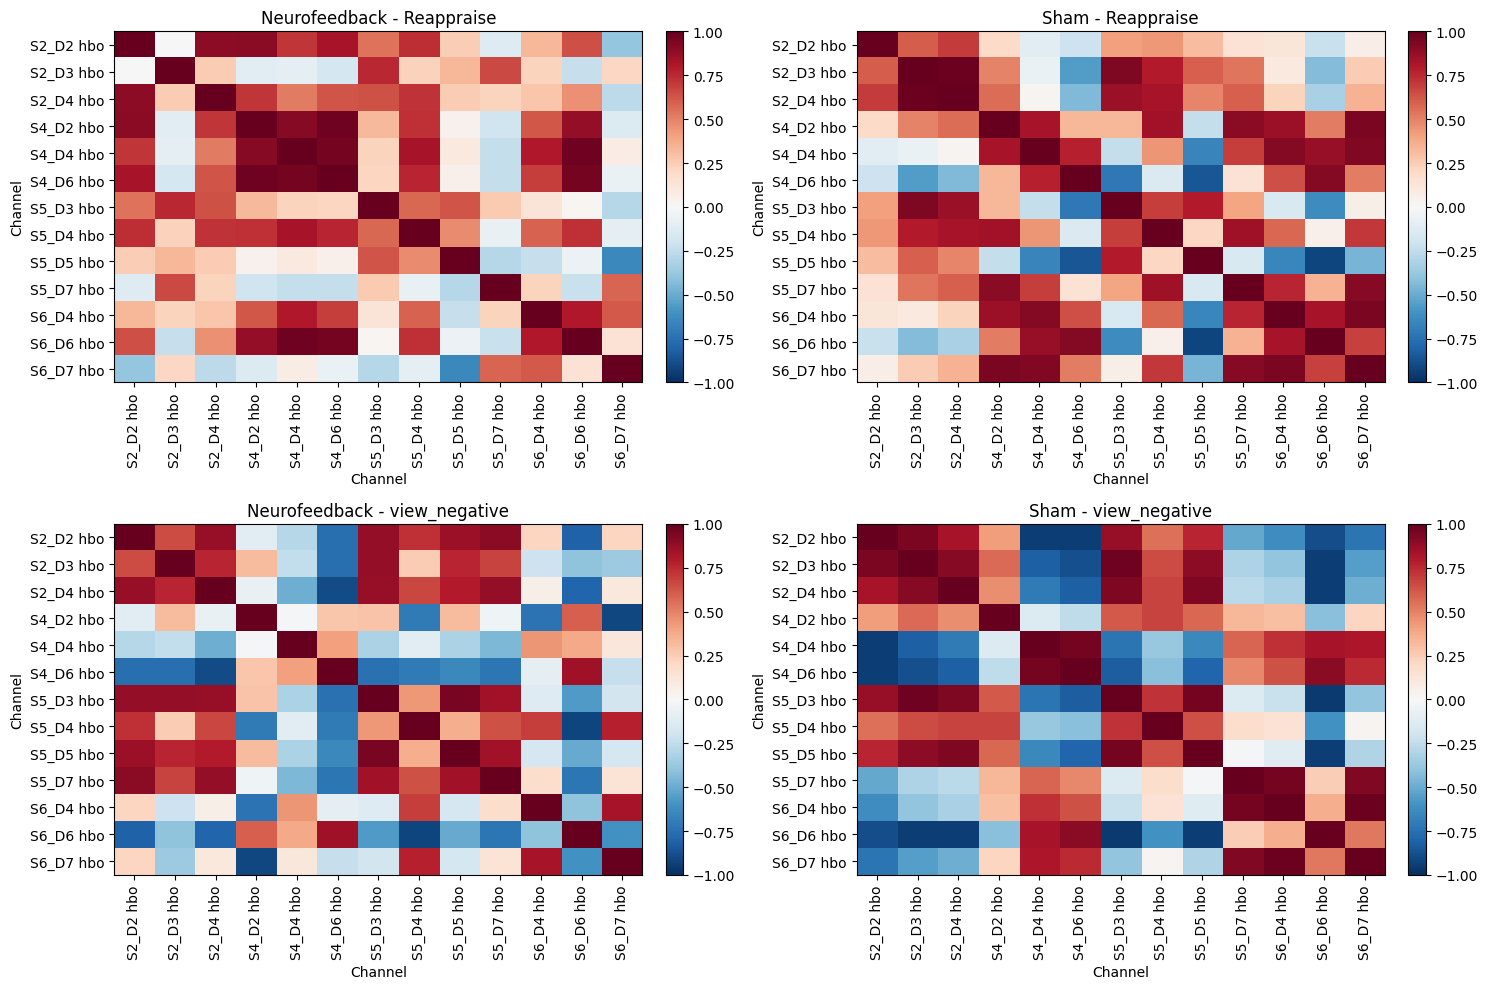

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_correlation_matrices(grand_averages, ch_names_hbo):
    """
    Plot correlation matrices comparing Neurofeedback and Sham groups for Reappraise and View Negative conditions.

    Parameters:
    - grand_averages (dict): Dictionary containing numpy arrays of grand average data
    - ch_names_hbo (list): List of HbO channel names
    """
    # Create a figure with 2x2 subplots for comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Conditions and groups to compare
    conditions = ['Reappraise/HbO', 'view_negative/HbO']
    groups = ['Neurofeedback', 'Sham']

    for row_idx, condition in enumerate(conditions):
        for col_idx, group in enumerate(groups):
            key = f'{group}/{condition}'
            data = grand_averages[key]
            corr_matrix = np.corrcoef(data)

            # Plot correlation matrix in subplot
            ax = axes[row_idx, col_idx]
            im = ax.imshow(corr_matrix, interpolation='none', aspect='auto',
                           cmap='RdBu_r', vmin=-1, vmax=1)
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

            # Set title and labels
            ax.set_title(f'{group} - {condition.split("/")[0]}')
            ax.set_xlabel('Channel')
            ax.set_ylabel('Channel')

            # Set tick labels
            ax.set_xticks(range(len(ch_names_hbo)))
            ax.set_xticklabels(ch_names_hbo, rotation='vertical')
            ax.set_yticks(range(len(ch_names_hbo)))
            ax.set_yticklabels(ch_names_hbo)

    plt.tight_layout()
    plt.show()

# Example function call
plot_correlation_matrices(grand_averages, hbo_ch_names)


In [ ]:
def plot_correlation_matrices(grand_averages, ch_names_hbo, ch_names_hbr):
    """
    Plot correlation matrices for HbO and HbR channels for each condition.

    Parameters:
    - grand_averages (dict): Dictionary containing numpy arrays of grand average data
    - ch_names_hbo (list): List of HbO channel names
    - ch_names_hbr (list): List of HbR channel names
    """
    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()  # Flatten axes array for easier indexing

    # Define which channel names to use for each condition
    ch_names_dict = {
        'Reappraise/HbO': ch_names_hbo,
        'view_negative/HbO': ch_names_hbo,
        'Reappraise/HbR': ch_names_hbr,
        'view_negative/HbR': ch_names_hbr
    }

    # Plot each condition in a subplot
    for idx, condition in enumerate(grand_averages):
        if idx >= 4:  # Skip if more than 4 conditions (2x2 limit)
            break

        # Calculate correlation matrix across channels
        # Transpose data to get channels x time points
        data = grand_averages[condition]
        corr_matrix = np.corrcoef(data)

        # Get channel names for this condition
        ch_names = ch_names_dict[condition]

        # Plot correlation matrix in subplot
        im = axes[idx].imshow(corr_matrix, interpolation='none', aspect='auto',
                            cmap='RdBu_r', vmin=-1, vmax=1)
        fig.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)

        # Set title and labels
        axes[idx].set_title(f'Correlation Matrix - {condition}')
        axes[idx].set_xlabel('Channel')
        axes[idx].set_ylabel('Channel')

        # Set tick labels
        axes[idx].set_xticks(range(len(ch_names)))
        axes[idx].set_xticklabels(ch_names, rotation='vertical')
        axes[idx].set_yticks(range(len(ch_names)))
        axes[idx].set_yticklabels(ch_names)

    # Remove empty subplots if less than 4 conditions
    for idx in range(len(grand_averages), 4):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

plot_correlation_matrices(grand_averages, hbo_ch_names, hbr_ch_names)